In [1]:
import numpy as np
import pandas as pd
import datajoint as dj
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

In [ ]:
    #    "R500", "R501" , "R502", "R503", "R600",
    #     "R610", "R611", "R612", "R613", "R614"

    #    "Y500", "Y501" , "Y502", "Y503", "Y600", Y601
    #     "Y510", "Y511", "Y512", "Y513", "Y514"

    #    "W600", "W601" , "W602", "W603", 
    #     "W510", "W511", "W512", "W513", "W514"

In [24]:
MODE = "online"
if MODE == "online":
    ratinfo = dj.create_virtual_module("intfo", "ratinfo")

    ANIMALS =  [
       "W600", "W601" , "W602", "W603", 
        "W510", "W511", "W512", "W513", "W514"
    ]
    
    Mass_keys = [{"ratname": animal} for animal in ANIMALS]
    mass_df = pd.DataFrame((ratinfo.Mass & Mass_keys).fetch(as_dict=True))
    mass_df['mass'] = mass_df['mass'].replace(0, np.nan)
    mass_df.to_csv("mass_Ws.csv", index=False)
    
if MODE == "offline":
    mass_df = pd.read_csv("mass.csv")

In [25]:
mass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   mass      913 non-null    object         
 1   weighing  962 non-null    int64          
 2   date      962 non-null    object         
 3   ratname   962 non-null    object         
 4   tech      962 non-null    object         
 5   timeval   962 non-null    timedelta64[ns]
dtypes: int64(1), object(4), timedelta64[ns](1)
memory usage: 45.2+ KB


### Calculate baseline weight- minimum date

In [26]:
# Convert the columns to numeric data type if needed
mass_df['mass'] = pd.to_numeric(mass_df['mass'], errors='coerce')

baseline_df = mass_df.groupby('ratname').agg({'date': 'min', 'mass': 'first'}).reset_index()
baseline_df.columns = ['ratname', 'min_date', 'min_date_mass']

mass_df = pd.merge(mass_df, baseline_df, on='ratname', how='left')
mass_df["min_date_relative"] = (mass_df['mass'] / mass_df['min_date_mass']).round(2)

mass_df['min_date_diff'] = mass_df.groupby('ratname')['min_date_relative'].diff()


## Plot

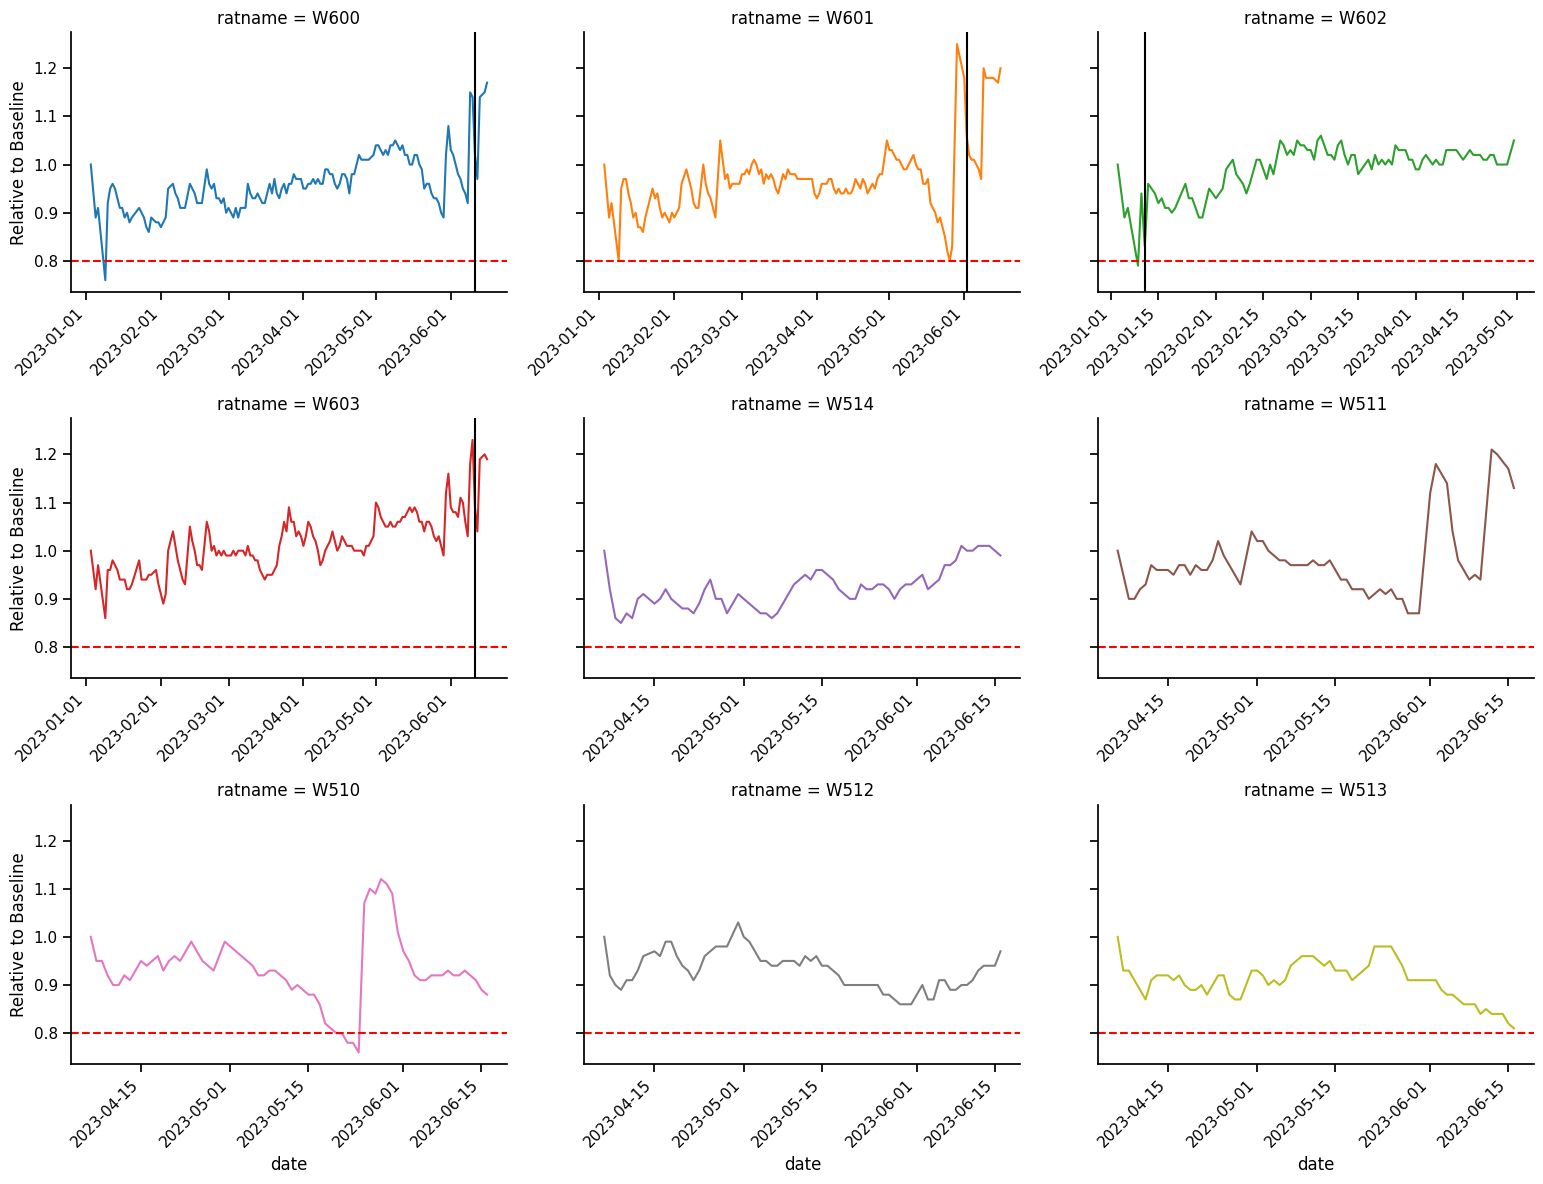

In [27]:
# Create the facet grid plot
g = sns.FacetGrid(
    data=mass_df, 
    col="ratname", 
    col_wrap=3, 
    hue="ratname", 
    height=4,
    sharex=False,
    aspect=1.3,
)
g.map(sns.lineplot, "date", "min_date_relative")
g.map(plt.axhline, y=0.80, color="red", linestyle="--")
g.set_xticklabels(rotation=45, ha='right')
# g.set_xticklabels()
g.fig.tight_layout()
g.set_axis_labels(y_var= "Relative to Baseline")

# plot a vertical line every time there is more than a 10% drop day-to-day
for ax, ratname in zip(g.axes.flat, g.col_names):
    filtered_df = mass_df[mass_df['ratname'] == ratname]
    for _, row in filtered_df[filtered_df['min_date_diff'] < -0.10].iterrows():
        ax.axvline(x=row['date'], color='black')



Possible ideas:
* what was the first training day for the above animals?
* could there be a window of time that's more appropriate than the first day? Ie first 7 masses?

In [28]:
summary_df = mass_df.groupby("ratname").date.min().reset_index()
summary_df["n_weights"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").mass.count()
)
summary_df["n_weights"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").mass.count()
)
summary_df["min_weight"] = summary_df["ratname"].map(
    mass_df.query("mass > 0").groupby("ratname").mass.min()
)

summary_df["max_weight"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").mass.max()
)

summary_df["min_date_weight"] = summary_df["ratname"].map(
    mass_df.groupby("ratname").min_date_mass.min()
)

summary_df

,ratname,date,n_weights,min_weight,max_weight,min_date_weight
0,W510,2023-04-06,70,16.60,24.35,21.70
1,W511,2023-04-06,66,19.70,27.37,22.66
2,W512,2023-04-06,70,20.52,24.69,23.96
3,W513,2023-04-06,70,21.40,26.51,26.51
4,W514,2023-04-06,70,20.49,24.40,24.08
5,W600,2022-12-08,154,16.61,25.61,21.97
6,W601,2022-12-08,151,16.99,26.49,21.21
7,W602,2022-12-08,108,16.12,21.50,20.29
8,W603,2022-12-08,154,17.29,24.64,20.04
